In [1]:
import warnings
warnings.filterwarnings('ignore')

## Loading APIs

In [2]:
from dotenv import load_dotenv
_ = load_dotenv()

# Tracking the project

In [3]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "email_job_agent"

## Setup User's Profile

In [4]:
profile = {
    "name": "Valentin",
    "full_name": "Valentin Jimenez",
    "user_profile_background": "Student using AI tools to leverage learning",
}

#  Prompt instructions and email example

In [5]:
prompt_classification_instructions = {
    "email_rules": {
        "ignore": "Marketing newsletters, spam emails, mass company announcements.",
        "notify": "Job offers, job listings, and company announcements realted to AI agents",
        "respond": "Direct messages from recruiters, customer inquiries, and urgent project requests.",
    },
    "agent_instructions": "Use these tools when appropriate to help manage Valentin's tasks efficiently."
}

In [6]:
# Example incoming email, as part of initial few shot prompting
email_example_1 = {
    "from": "Victor Alejandro <victor.alejandro@company.com>",
    "to": "Valentin Jimenez <my_email@gmail.com>",
    "subject": "Quick question about your expierience with AI agents frameworks",
    "body": """
Hi Valentin,

We have a project where we think we can leverage the power of AI to improve our product. 
I was wondering if you have any experience with Langraph or Crew AI frameworks?

Hope you cant take a look as soon as possible since we are close to the deadline.

Thanks!
Victor""",
}

## Define response system

During prototype face I will use a mock email service. Later I need to use a real email service.

In [7]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated
from langchain.chat_models import init_chat_model

In [8]:
llm = init_chat_model("openai:gpt-4o-mini")

Using pydantic to generate a specified structured output

In [9]:
class Router_pydantic(BaseModel):
    """Analyze the new unread email and route it according to its content."""

    reasoning: str = Field(
        description="Step-by-step reasoning behind the classification."
    )
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply",
    )

In [10]:
llm_router = llm.with_structured_output(Router_pydantic)

In [11]:
llm_router

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x0000020E20EDD6A0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000020E20EDE120>, root_client=<openai.OpenAI object at 0x0000020E20AC8AD0>, root_async_client=<openai.AsyncOpenAI object at 0x0000020E20EDD7F0>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'response_format': <class '__main__.Router_pydantic'>, 'ls_structured_output_format': {'kwargs': {'method': 'json_schema', 'strict': None}, 'schema': {'type': 'function', 'function': {'name': 'Router_pydantic', 'description': 'Analyze the new unread email and route it according to its content.', 'parameters': {'properties': {'reasoning': {'description': 'Step-by-step reasoning behind the classification.', 'type': 'string'}, 'classification': {'description': "The classification of an email: 'ignore' for irrelevant emails, 'notify' for imp

In [12]:
from prompts import email_classification_system_prompt, email_user_prompt

In [13]:
system_prompt = email_classification_system_prompt.format(
    full_name=profile["full_name"],
    name=profile["name"],
    examples=None,
    user_profile_background=profile["user_profile_background"],
    email_no=prompt_classification_instructions["email_rules"]["ignore"],
    email_notify=prompt_classification_instructions["email_rules"]["notify"],
    email_respond=prompt_classification_instructions["email_rules"]["respond"],
)

In [14]:
user_prompt = email_user_prompt.format(
    author=email_example_1["from"],
    to=email_example_1["to"],
    subject=email_example_1["subject"],
    email_thread=email_example_1["body"],
)

In [15]:
result = llm_router.invoke(
    [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ]
)

In [16]:
# Here maybe use another agent to produce more emails and test the system message, trace with opik for instance??
# fine tune with emails classification?
print(result)

reasoning="This email is a direct inquiry about Valentin's experience with specific AI frameworks, Langraph and Crew AI. It comes from Victor Alejandro, who presumably has a project that could involve Valentin's expertise. The urgency expressed with 'close to the deadline' indicates it is important and requires a timely response. Therefore, it falls into the category of needing a direct response from Valentin." classification='respond'


## Main agent: Tools definition

In [17]:
from langchain_core.tools import tool

In [18]:
# Here is where the connection with the API must be made
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder
    return f"Email sent to {to} with subject '{subject}'"

In [19]:
# This one too, connect with calendars API's
@tool
def schedule_meeting(
    attendees: list[str], 
    subject: str, 
    duration_minutes: int, 
    preferred_day: str
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder
    return f"Meeting '{subject}' scheduled for {preferred_day} with {len(attendees)} attendees"

In [20]:
@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available time on {day}: 9:00 AM"

### Memory management: creation and tool definition

In [54]:
from memory_setup.qdrant.qdrantVectorStoreLocal import QdrantVectorStoreManager
from memory_setup.qdrant.qdrantBaseStoreWrapper import QdrantBaseStoreWrapper

langgraph_user_id = "Valentin"  # Request to the user 
collection_name = f"email_job_agent_memory_{langgraph_user_id}"

# Get or create a vector store
qdrant_manager = QdrantVectorStoreManager()
qdrant_vectorstore = qdrant_manager.get_vectorstore(collection_name)

- Using buil-in create_manage_memory_tool and search_manage_memory_tool

In [22]:
from langmem import create_manage_memory_tool, create_search_memory_tool

namespace = ("email_job_assistant_memory", "{langgraph_user_id}", "collection_semantic_memory")
store_wrapper = QdrantBaseStoreWrapper(qdrant_vectorstore, namespace=namespace)

manage_memory_tool = create_manage_memory_tool(
    namespace=namespace,
    store=store_wrapper
)

search_memory_tool = create_search_memory_tool(
    namespace=namespace,
    store=store_wrapper  
)

In [23]:
print(manage_memory_tool.name,end="\n\n")
print("Descrition manage: ",manage_memory_tool.description, end="\n\n")
print("Descrition search: ",search_memory_tool.description)

manage_memory

Descrition manage:  Create, update, or delete a memory to persist across conversations.
Include the MEMORY ID when updating or deleting a MEMORY. Omit when creating a new MEMORY - it will be created for you.
Proactively call this tool when you:

1. Identify a new USER preference.
2. Receive an explicit USER request to remember something or otherwise alter your behavior.
3. Are working and want to record important context.
4. Identify that an existing MEMORY is incorrect or outdated.

Descrition search:  Search your long-term memories for information relevant to your current context.


In [24]:
# # Adding an entry
# qdrant_vectorstore.add_texts(["Valentin Is booking a trip"])

# # Search (similarity)
# results = qdrant_vectorstore.similarity_search("who is booking a trip", k=2)

# for r in results:
#     print(r.page_content)


## Main agent: initial system prompt creation

In [25]:
from prompts import agent_system_prompt_memory
def create_prompt(state):
    return [
        {
            "role": "system", 
            "content": agent_system_prompt_memory.format(
                instructions=prompt_classification_instructions["agent_instructions"],
                **profile
                )
        }
    ] + state['messages']

In [26]:
print(agent_system_prompt_memory)


< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about managing {name}'s job applications.
</ Role >

< Tools >
You have access to the following tools to help manage {name}'s communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
4. manage_memory - Store any relevant information about contacts, actions, discussion, etc. in memory for future reference
5. search_memory - Search for any relevant information that may have been stored in memory
</ Tools >

< Instructions >
{instructions}
</ Instructions >



# Main agent state

In [27]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from IPython.display import Image, display

In [28]:
from langgraph.graph import add_messages

class State(TypedDict):
    email_input: dict
    messages: Annotated[list, add_messages]

# Defining Main Agent graph Nodes

## Subagent Node
### Using the prebuil create_react_agent

This will be a subagent deciding what tool to use according to the received email

In [29]:
from langgraph.prebuilt import create_react_agent

In [30]:
tools=[
    write_email, 
    schedule_meeting, 
    check_calendar_availability,
    manage_memory_tool,
    search_memory_tool
    ]

In [31]:
response_agent = create_react_agent(
    "openai:gpt-4o-mini",
    tools=tools,
    prompt=create_prompt,
    store=store_wrapper
)

Testing the create_react_agent agent. Note that this has not the first defined structured output

In [32]:
config = {"configurable": {"langgraph_user_id": langgraph_user_id}}

Notice that the next call does not store anything in qdrant because it's not related to:

4. manage_memory - Store any relevant information about contacts, actions, discussion, etc. in memory for future reference

as indicated in the instructions

In [33]:
# This one did not store anything because it's not adding important info about the user
response = response_agent.invoke(
    {"messages": [{
        "role": "user", 
        "content": "what is my availability for tuesday?"
    }]},config=config
)

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is my availability for tuesday?
================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_YQotLcmoPDRzfHZcX3wgbJ0L)
 Call ID: call_YQotLcmoPDRzfHZcX3wgbJ0L
  Args:
    day: Tuesday
================================= Tool Message =================================
Name: check_calendar_availability

Available time on Tuesday: 9:00 AM
================================== Ai Message ==================================

You have availability at 9:00 AM on Tuesday.


In [34]:
# This is relevant to the user so the agent should store the info in the database
response = response_agent.invoke(
    {"messages": [{
        "role": "user", 
        "content": "Valentin likes pizza"
    }]},config=config
)

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Valentin likes pizza
================================== Ai Message ==================================
Tool Calls:
  manage_memory (call_r35KxRGuZCzmjGSJpCl2Czn1)
 Call ID: call_r35KxRGuZCzmjGSJpCl2Czn1
  Args:
    content: Valentin likes pizza
    action: create
================================= Tool Message =================================
Name: manage_memory

created memory 324aea87-256f-4ab8-9710-47f02931f476
================================== Ai Message ==================================

I've noted that Valentin likes pizza! If there's anything else you'd like me to remember or help with, just let me know.


In [35]:
# This should look for information in the database
response = response_agent.invoke(
    {"messages": [{
        "role": "user", 
        "content": "What does Valentin like?"
    }]},config=config
)

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What does Valentin like?
================================== Ai Message ==================================
Tool Calls:
  search_memory (call_OBqQzk5k47q0yT4nGvg6kwj8)
 Call ID: call_OBqQzk5k47q0yT4nGvg6kwj8
  Args:
    query: Valentin's preferences
================================= Tool Message =================================
Name: search_memory

[{"id":"4d3620a0-b6f0-4709-aa70-37d06a51601f","metadata":{"namespace":"email_job_assistant_memory/Valentin/collection_semantic_memory","key":"324aea87-256f-4ab8-9710-47f02931f476"},"page_content":"Valentin likes pizza","type":"Document"}]
================================== Ai Message ==================================

Valentin likes pizza. If there's anything specific you would like to know or track regarding his preferences, feel free to ask!


In [52]:
response_agent.invoke(
    {"messages": [{
        "role": "user", 
        "content": "Valentin is a Mathematician"
    }]},config=config
)

{'messages': [HumanMessage(content='Valentin is a Mathematician', additional_kwargs={}, response_metadata={}, id='e14e357a-31ce-4f6b-bb71-463909cc5c03'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TjJcrryXuMEfkN0vjoE7m6lG', 'function': {'arguments': '{"content":"Valentin is a Mathematician.","action":"create"}', 'name': 'manage_memory'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 504, 'total_tokens': 529, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BfDzwzbXgvsU5vS5QaUB0ze7ZHDmY', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--bf67469d-e93f-4408-99de-45cea1350d78-0', tool_calls=[{'name': 'manage_

In [51]:

store_wrapper.search(('email_job_assistant_memory',
                      'Valentin',
                      'collection_semantic_memory'), query="pizza")

[Document(id='4d3620a0-b6f0-4709-aa70-37d06a51601f', metadata={'namespace': 'email_job_assistant_memory/Valentin/collection_semantic_memory', 'key': '324aea87-256f-4ab8-9710-47f02931f476'}, page_content='Valentin likes pizza')]

In [53]:
store_wrapper.search(('email_job_assistant_memory',
                      'Valentin',
                      'collection_semantic_memory'), query="valentin")

[Document(id='30bd3795-ca9e-4d81-98a6-c678fe5054a6', metadata={'namespace': 'email_job_assistant_memory/Valentin/collection_semantic_memory', 'key': 'd1c4c74c-5544-43a3-91c8-608562e729f2'}, page_content='Valentin is a Mathematician.'),
 Document(id='4d3620a0-b6f0-4709-aa70-37d06a51601f', metadata={'namespace': 'email_job_assistant_memory/Valentin/collection_semantic_memory', 'key': '324aea87-256f-4ab8-9710-47f02931f476'}, page_content='Valentin likes pizza')]

In [37]:
# # Let's see if it can delete all entries
# # This needs to be implemented later. Meanwhile I can use directly the qdrant_manager
# response = response_agent.invoke(
#     {"messages": [{
#         "role": "user", 
#         "content": "Can you delete all information you have stored about me?"
#     }]},config=config
# )

# for m in response["messages"]:
#     m.pretty_print()

### Cleaning up the database while testing

In [38]:
# Use this to cleanup a bit after testing
# qdrant_manager.delete_all_entries("email_job_agent_memory_Valentin")

## Router Node

In [39]:
def router_node(state: State) -> Command[
    Literal["response_agent", "__end__"]
]:
    author = state['email_input']['author']
    to = state['email_input']['to']
    subject = state['email_input']['subject']
    email_thread = state['email_input']['email_thread']

    system_prompt = email_classification_system_prompt.format(
        full_name=profile["full_name"],
        name=profile["name"],
        examples=None,
        user_profile_background=profile["user_profile_background"],
        email_no=prompt_classification_instructions["email_rules"]["ignore"],
        email_notify=prompt_classification_instructions["email_rules"]["notify"],
        email_respond=prompt_classification_instructions["email_rules"]["respond"],
    )
    user_prompt = email_user_prompt.format(
        author=author, 
        to=to, 
        subject=subject, 
        email_thread=email_thread
    )
    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )
    if result.classification == "respond":
        print("✅ Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email {state['email_input']}",
                }
            ]
        }
    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        update = None
        goto = END
        
        
    elif result.classification == "notify":        
        print("🔔 Classification: NOTIFY - This email contains important information")
        update = None
        goto = END
    else:
        raise ValueError(f"Invalid classification: {result.classification}")
    return Command(goto=goto, update=update)

# Defining the Main Agent Graph

In [40]:
graph_builder = StateGraph(State)
graph_builder = graph_builder.add_node(router_node)
graph_builder = graph_builder.add_node("response_agent", response_agent)

graph_builder = graph_builder.add_edge(START, "router_node")
email_agent = graph_builder.compile()

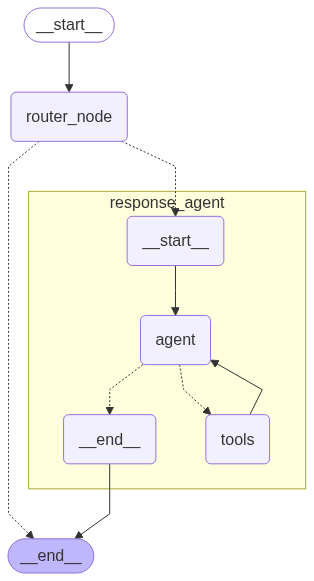

In [41]:
# Show the agent
display(Image(email_agent.get_graph(xray=True).draw_mermaid_png()))

In [42]:
email_input = {
    "author": "Marketing Team <marketing@amazingdeals.com>",
    "to": "Valentin Jimenez <my_email@gmail.com>",
    "subject": "🌟 NEW RELEASE: Supercharge Your Workflow with Our Latest Dev Tools! 🌟",
    "email_thread": """Dear Valued Developer,

We’re thrilled to announce the launch of something truly game-changing!

💡 Introducing the NEXT-GEN Developer Productivity Pack – built to accelerate your workflow and maximize efficiency!

✨ HIGHLIGHTS:
- Lightning-fast debugging assistant
- Seamless integration with popular frameworks
- Automated performance optimization
- Lifetime access to new features

Best regards,
Marketing Team
---
To unsubscribe, click here
""",
}


In [43]:
response = email_agent.invoke({"email_input": email_input})

🚫 Classification: IGNORE - This email can be safely ignored


In [44]:
email_input = {
    "author": "Victor Gomez <victor.gomez@company.com>",
    "to": "Valentin Jimenez <my_email@gmail.com>",
    "subject": "Quick question about your employment availability",
    "email_thread": """Hi Valentin,

I hope you're doing well.

I wanted to check in and see what your current availability looks like for potential employment opportunities. 
We're exploring a few upcoming projects that could be a great fit for your skill set, and I’d love to know if 
you're open to discussing something in the near future.

Let me know when you’d be available for a quick chat.

Best,  
Victor""",
}



In [45]:
response = email_agent.invoke({"email_input": email_input})

✅ Classification: RESPOND - This email requires a response


In [46]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Victor Gomez <victor.gomez@company.com>', 'to': 'Valentin Jimenez <my_email@gmail.com>', 'subject': 'Quick question about your employment availability', 'email_thread': "Hi Valentin,\n\nI hope you're doing well.\n\nI wanted to check in and see what your current availability looks like for potential employment opportunities. \nWe're exploring a few upcoming projects that could be a great fit for your skill set, and I’d love to know if \nyou're open to discussing something in the near future.\n\nLet me know when you’d be available for a quick chat.\n\nBest,  \nVictor"}
================================== Ai Message ==================================
Tool Calls:
  write_email (call_UfRMA2bZxp1p8aNus9byACTr)
 Call ID: call_UfRMA2bZxp1p8aNus9byACTr
  Args:
    to: Victor Gomez <victor.gomez@company.com>
    subject: Re: Quick question about your employment availability
    conte